## 1. Prepare the data

Check for any missing values and handle them if they are present. 


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score


df = pd.read_csv("customer_data_large.csv")


print(df.head())  
print(df.info())
print(df.isnull().sum())
print(df.describe()) 

df.dropna(inplace=True) 

   Education  Kidhome  Recency  MntWines  MntFruits  MntSweetProducts  \
0          3        0       58       635         88                88   
1          3        1       38        11          1                 1   
2          3        0       26       426         49                21   
3          3        1       26        11          4                 3   
4          5        1       94       173         43                27   

   MntGoldProds  NumWebPurchases  NumStorePurchases  NumWebVisitsMonth  Age  \
0            88                8                  4                  7   65   
1             6                1                  2                  5   63   
2            42                8                 10                  4   57   
3             5                7                  4                  6   38   
4            15                5                  6                  5   41   

   Years_customer  Num_AcceptedCmp  MntFishMeatProdcts  
0              10            

Scale the data (for this problem, it is recommended to use the MinMax scaler).

In [4]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

print(df_scaled.head())

   Education  Kidhome   Recency  MntWines  MntFruits  MntSweetProducts  \
0        0.5      0.0  0.585859  0.425318   0.442211          0.334601   
1        0.5      0.5  0.383838  0.007368   0.005025          0.003802   
2        0.5      0.0  0.262626  0.285332   0.246231          0.079848   
3        0.5      0.5  0.262626  0.007368   0.020101          0.011407   
4        1.0      0.5  0.949495  0.115874   0.216080          0.102662   

   MntGoldProds  NumWebPurchases  NumStorePurchases  NumWebVisitsMonth  \
0      0.243094          0.25000           0.307692               0.35   
1      0.016575          0.03125           0.153846               0.25   
2      0.116022          0.25000           0.769231               0.20   
3      0.013812          0.21875           0.307692               0.30   
4      0.041436          0.15625           0.461538               0.25   

        Age  Years_customer  Num_AcceptedCmp  MntFishMeatProdcts  
0  0.709091             1.0              0.

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/

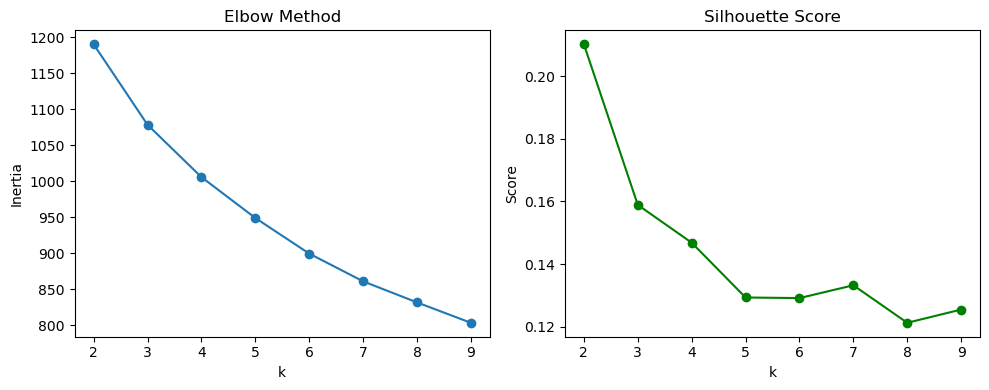

In [8]:
inertia = []
silhouette = []
calinski = []
k_range = range(2, 10)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_scaled)
    inertia.append(model.inertia_)
    silhouette.append(silhouette_score(df_scaled, model.labels_))
    calinski.append(calinski_harabasz_score(df_scaled, model.labels_))

# Elbow method plot
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('Inertia')

# Silhouette score plot
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('Score')
plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster centers (original scale):
    Education   Kidhome    Recency    MntWines  MntFruits  MntSweetProducts  \
0   3.512894  0.765043  49.326648   63.071633   5.091691          5.275072   
1   3.661458  0.088542  53.927083  749.953125  53.182292         54.682292   
2   3.260714  0.802381  47.991667   75.728571   6.598810          7.355952   
3   3.564688  0.024353  47.805175  463.505327  46.937595         47.864536   

   MntGoldProds  NumWebPurchases  NumStorePurchases  NumWebVisitsMonth  \
0     12.650430         3.163324           3.512894           7.343840   
1     72.223958         6.880208           8.502604           7.479167   
2     24.677381         3.788095           3.530952           8.548810   
3     68.351598         5.908676           8.322679           4.919330   

         Age  Years_customer  Num_AcceptedCmp  MntFishMeatProdcts  
0  50.025788        8.000000         0.166189           39.851003  
1  52.296875        9.658854         1.236979          447.718750 

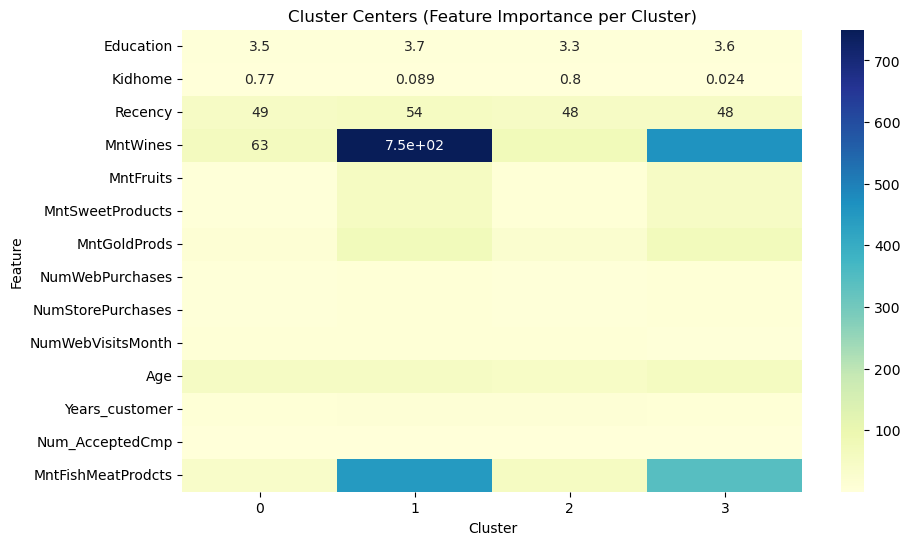

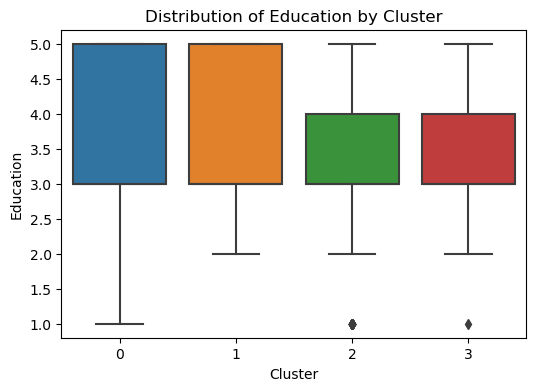

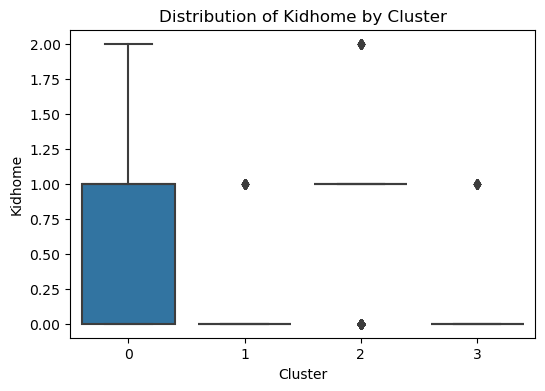

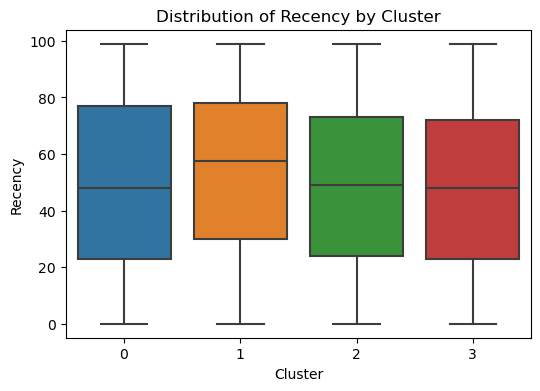

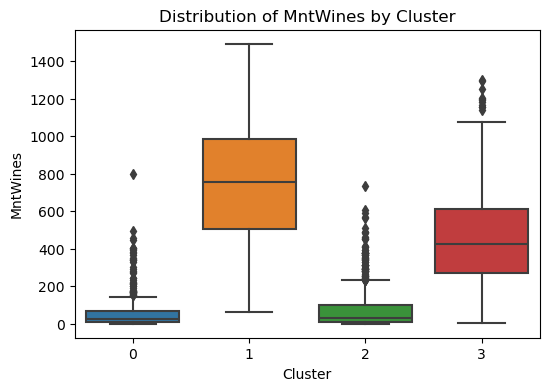

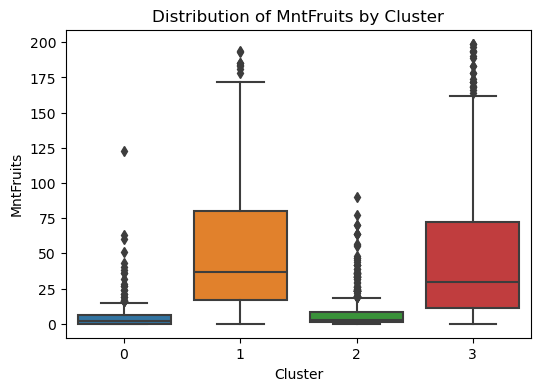

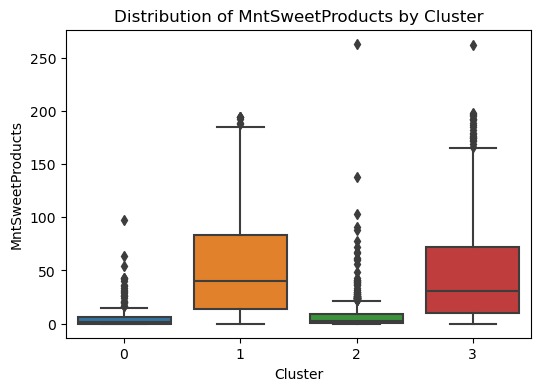

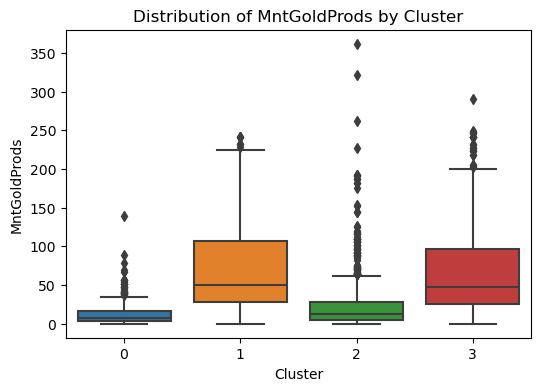

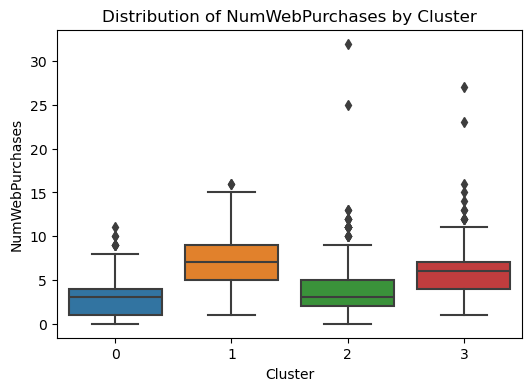

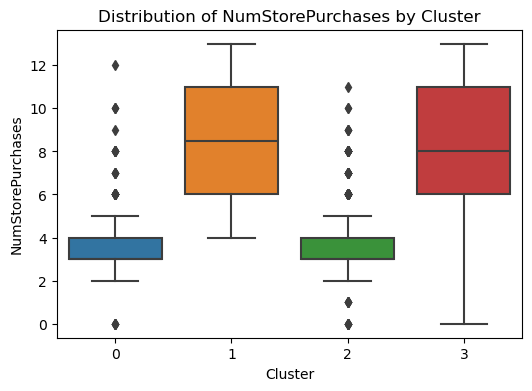

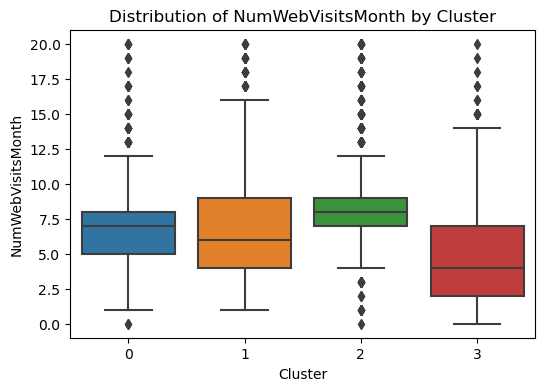

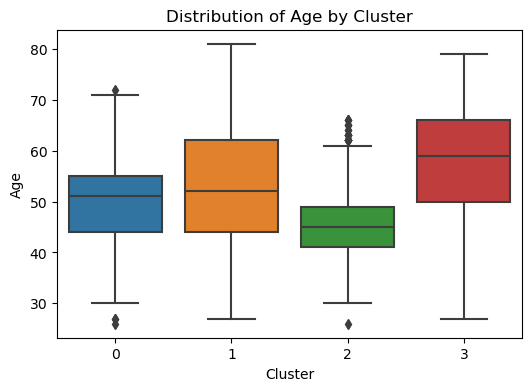

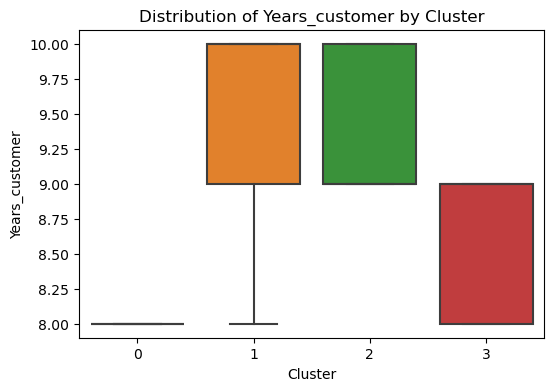

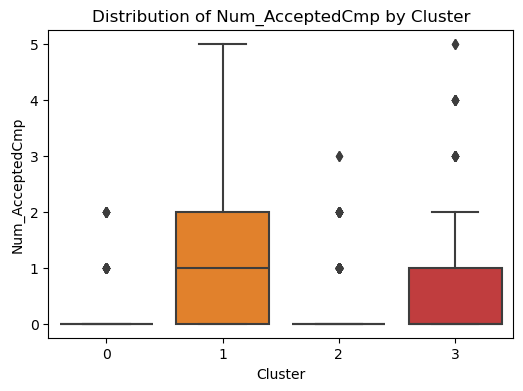

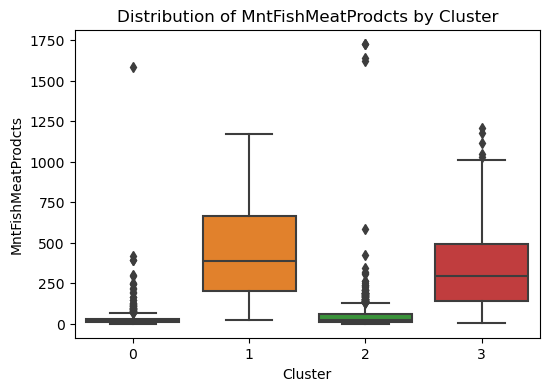


Cluster Profiles:
          Education   Kidhome    Recency    MntWines  MntFruits  \
Cluster                                                          
0         3.512894  0.765043  49.326648   63.071633   5.091691   
1         3.661458  0.088542  53.927083  749.953125  53.182292   
2         3.260714  0.802381  47.991667   75.728571   6.598810   
3         3.564688  0.024353  47.805175  463.505327  46.937595   

         MntSweetProducts  MntGoldProds  NumWebPurchases  NumStorePurchases  \
Cluster                                                                       
0                5.275072     12.650430         3.163324           3.512894   
1               54.682292     72.223958         6.880208           8.502604   
2                7.355952     24.677381         3.788095           3.530952   
3               47.864536     68.351598         5.908676           8.322679   

         NumWebVisitsMonth        Age  Years_customer  Num_AcceptedCmp  \
Cluster                           

In [9]:
# 3. Tren modellen med valgt k (basert på plottene – her bruker vi f.eks. k=4)
best_k = 4
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(df_scaled)
df['Cluster'] = kmeans.labels_

# 4. Analyser klyngene
centers = pd.DataFrame(kmeans.cluster_centers_, columns=df.columns[:-1])
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=df.columns[:-1])
print("\nCluster centers (original scale):\n", centers)

# Visualiser sentre som heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(centers.T, annot=True, cmap="YlGnBu")
plt.title("Cluster Centers (Feature Importance per Cluster)")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.show()

# Se fordeling av variabler per cluster
for col in df.columns[:-1]:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, x='Cluster', y=col)
    plt.title(f'Distribution of {col} by Cluster')
    plt.show()

# 5. Profilering av klyngene
cluster_profiles = df.groupby('Cluster').mean()
cluster_profiles['Count'] = df['Cluster'].value_counts()
print("\nCluster Profiles:\n", cluster_profiles)

# t-SNE

In [ ]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#columns_names = ["Education", "Kidhome", "Recency", "MntWines", "MntFruits", "MntSweetProducts", "MntGoldProds", "NumWebPurchases", "NumStorePurchases", "NumWebVisitsMonth", "Age", "Years_customer", "Num_AcceptedCmp", "MntFishMeatProdcts"]
df_customers = pd.read_csv('customer_data_large.csv')

In [ ]:
tsne = TSNE()
X_tsne = tsne.fit_transform(df_customers)

In [ ]:
dicc_tsne = {'comp_1':X_tsne[:,0],'comp_2':X_tsne[:,1]}
df_tsne = pd.DataFrame(dicc_tsne,index=df_customers.index)

<Axes: xlabel='comp_1', ylabel='comp_2'>

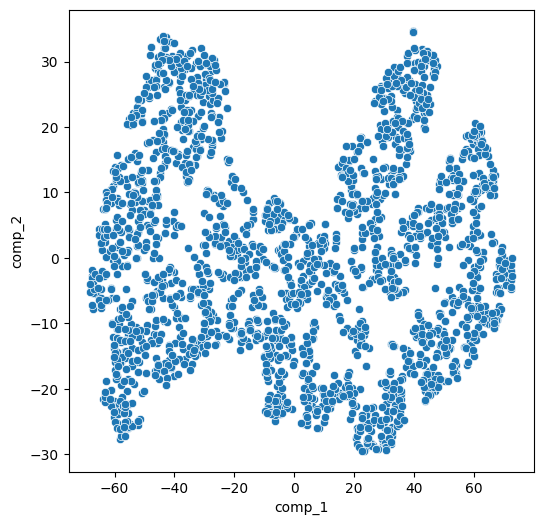

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_tsne, x='comp_1',y='comp_2', legend='full')

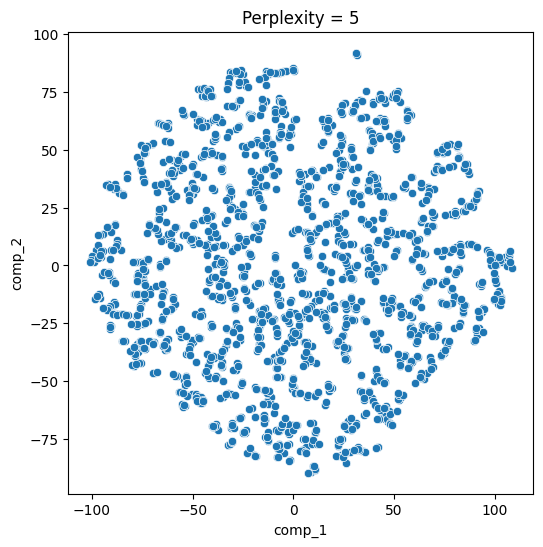

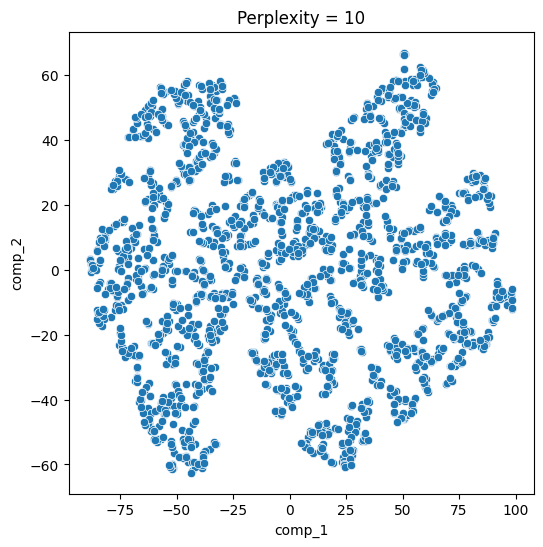

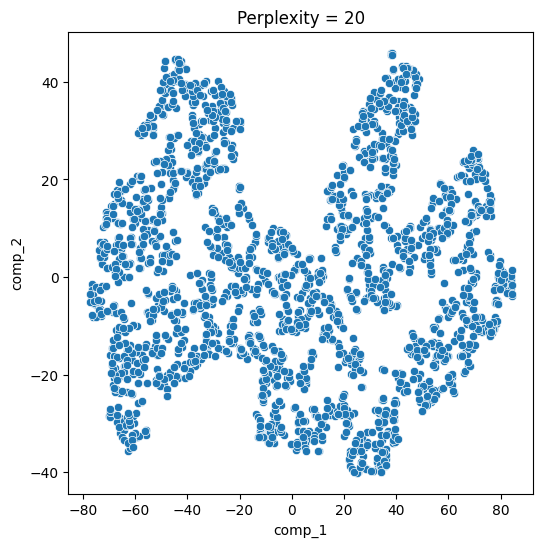

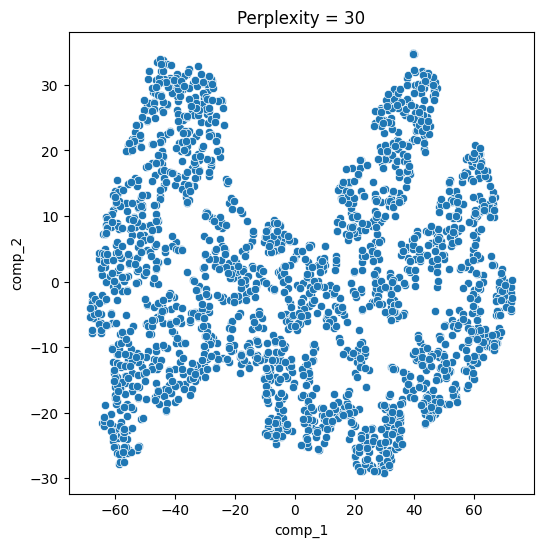

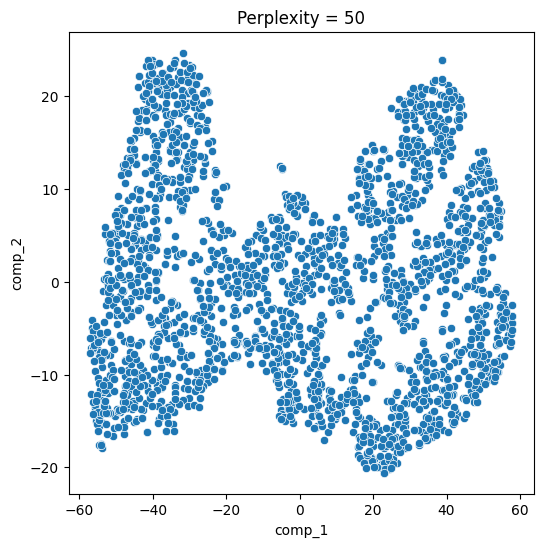

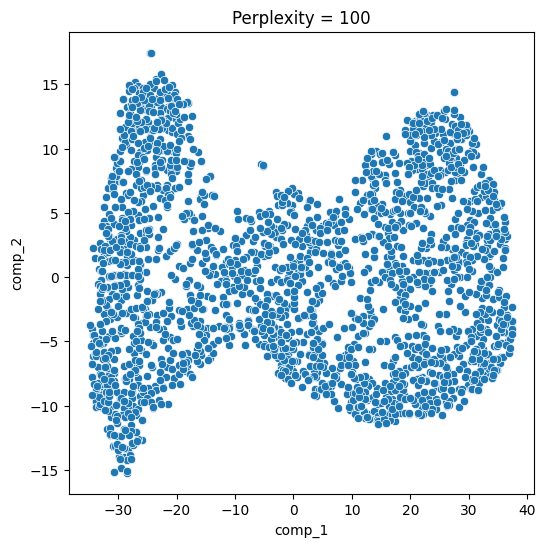

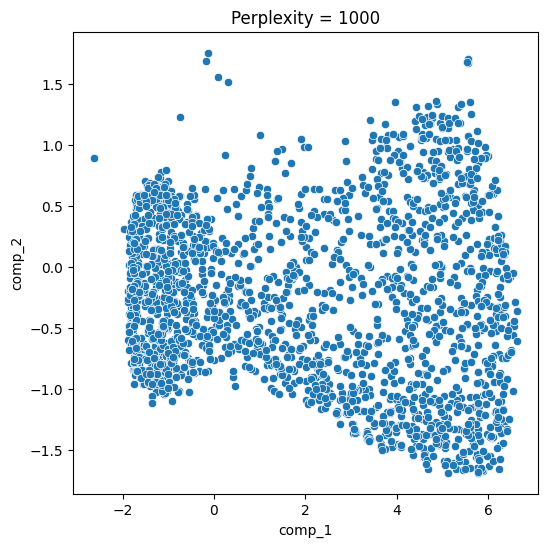

In [ ]:
for perp in [5,10,20,30,50,100,1000]:
  tsne = TSNE(perplexity=perp,random_state=72)
  X_tsne = tsne.fit_transform(df_customers)
  dicc_tsne = {'comp_1':X_tsne[:,0],'comp_2':X_tsne[:,1]}
  df_tsne = pd.DataFrame(dicc_tsne,index=df_customers.index)
  plt.figure(figsize=(6,6))
  plt.title('Perplexity = ' + str(perp))
  sns.scatterplot(data=df_tsne, x='comp_1',y='comp_2', legend='full')